# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [2]:
# Limit GPU memory usage

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    IMAGE_MAX_DIM=640
    IMAGE_META_SIZE=93
    IMAGE_MIN_DIM=480

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.3
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model_MaskRCNN = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model_MaskRCNN.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [6]:
## Run Object Detection

In [7]:
IMAGE_DIR = "/home/qiancheng/DISK/feiyu/TrainYolo/data_yolo/video_bottle/images"
IMAGE_DIR = "/home/qiancheng/DISK/feiyu/TrainYolo/data_yolo/video_meter/images"
IMAGE_DIR = "/home/qiancheng/DISK/feiyu/Detect-Hand-Grasping-Object/images"
print(IMAGE_DIR)

/home/qiancheng/DISK/feiyu/Detect-Hand-Grasping-Object/images


In [146]:
import copy

def get_attributes_of_target_objects(result, target_objects):
    results = copy.copy(result)

    target_indices = []
    for i, cid in enumerate(result["class_ids"]):
        if class_names[cid] in target_objects:
            target_indices.append(i)
    
    if len(target_indices)>0:

        target_names = [class_names[result["class_ids"][i]] for i in target_indices]
        print("Find following objects:", target_names)

        attributes = ['rois', 'class_ids', 'scores']
        for attr in attributes:
            result[attr] = np.array([result[attr][i,...] for i in target_indices])
        result['masks'] = result['masks'][:,:,np.array(target_indices)]

        return result
    else:
        return None
        

def find_desired_objects(results):
    target_objects =  ["cup", "bottle",'apple','banana','bowl']
    objects_info = get_attributes_of_target_objects(results[0], target_objects)
    
    if objects_info is None:
        print("No target object is detected")
        return None
    
    
    IF_SHOW = True
    
    bboxes = objects_info['rois']
    masks = objects_info['masks']
    class_ids = objects_info['class_ids']
    
    if IF_SHOW:
        visualize.display_instances(
            image, bboxes, masks, class_ids, class_names, objects_info['scores'])
    
    return bboxes # [[row0, col0, row1, col1],]

def compute_center():
    pass

In [160]:
def detect_objects_by_MaskRCNN(image):
    results = model_MaskRCNN.detect([image], verbose=0)
    bboxes = find_desired_objects(results)
    
    
def main():
    pass

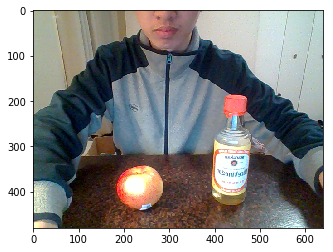

In [161]:
import cv2, time
import matplotlib.pyplot as plt
%matplotlib inline 
if 1:
    cap = cv2.VideoCapture(0)
    i=0
    while(True):
        # Capture frame-by-frame
        ret, imgsrc = cap.read()
        if ret:
            i+=1
        else:
            time.sleep(0.01)
        if i==10:
            break
    image=cv2.cvtColor(imgsrc, cv2.COLOR_BGR2RGB)
    image = np.fliplr(image)
    cap.release()
    plt.imshow(image)
    plt.show()

Find following objects: ['bottle', 'apple']


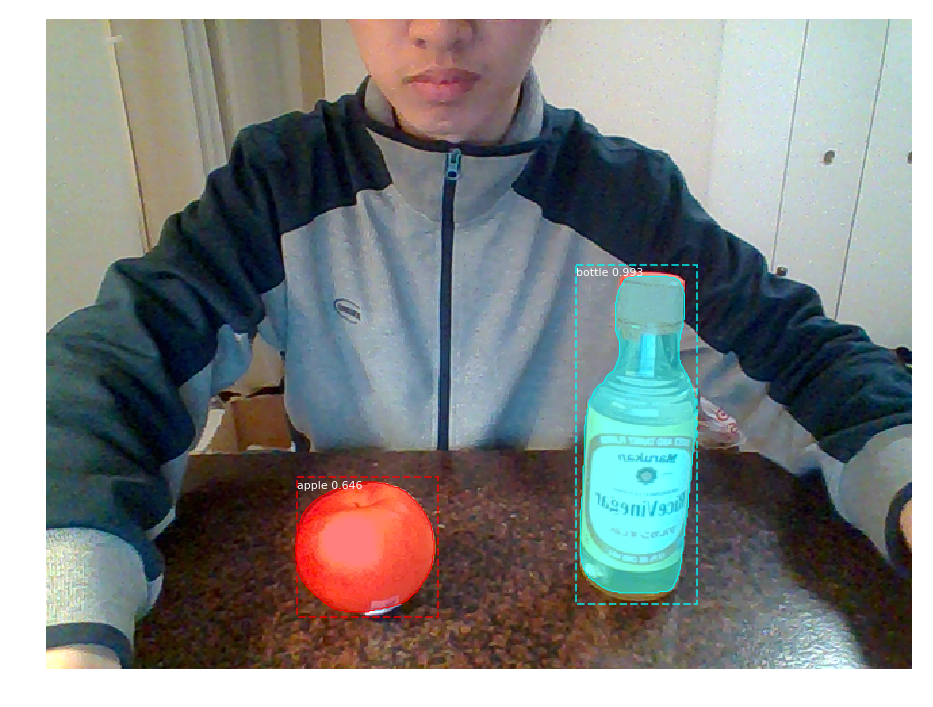

In [162]:
def load_an_image():
    if 0:
        # Load a random image from the images folder
        file_names = next(os.walk(IMAGE_DIR))[2]
        image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
        # plt.imshow(image)
    else:
        image_name = os.path.join(IMAGE_DIR, '00001.png')
        image = skimage.io.imread(image_name)
    return image

# Run detection
# image = load_an_image()
results = model_MaskRCNN.detect([image], verbose=0)

# Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])

bboxes = find_desired_objects(results)

In [163]:
def change_bboxes_coordinate(bboxes):
    # From: row0, col0, row1, col1
    # To: x, y, width, height
    bboxes_n = []
    for p in bboxes:
        row0, col0, row1, col1 = int(p[0]),int(p[1]),int(p[2]),int(p[3])
        bboxes_n.append([col0, row0, col1-col0, row1-row0])
    return bboxes_n
bboxes_n =  change_bboxes_coordinate(bboxes)
print(bboxes_n)

[[391, 181, 90, 251], [185, 338, 104, 103]]


In [164]:
filename_to_write_boxes_pos = "boxes_pos.txt" 
import simplejson
with open(filename_to_write_boxes_pos, 'w') as f:
    simplejson.dump(bboxes_n, f)